# Intelligent Customer Review Analysis — McDonald's Reviews

Objectif (pour le moment) :
- Exploration et préparation des données
- Analyse statistique des données
- Visualisation des distributions
- Gestion de la normalisation / standardisation / données manquantes
- Graphe comparatif : avant vs après prétraitement
- Séparation en jeux train / validation / test

Le CSV contient (attendu) : `reviewer_id`, `store_name`, `category`, `store_address`, `latitude`, `longitude`, `rating_count`, `review_time`, `review`, `rating`.

## 1) Import & configuration
Chargement des librairies et réglages d'affichage (pandas / seaborn).

In [12]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

## 2) Chargement des données
Lecture du fichier CSV et premier aperçu (shape + head).

In [13]:
# Chargement
DATA_PATH = Path('McDonald_s_Reviews.csv')
assert DATA_PATH.exists(), f'CSV introuvable: {DATA_PATH.resolve()}'

df_raw = pd.read_csv(DATA_PATH)
print('Shape:', df_raw.shape)
display(df_raw.head(5))

# Remarque: dans ce dataset, certains noms de colonnes peuvent contenir des espaces (ex: "latitude "),
# et `rating`/`rating_count` peuvent être stockés en texte (ex: "4 stars", "1,240").

Shape: (33396, 10)


,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was �����������...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


## 3) Exploration rapide
Types de colonnes, valeurs manquantes, et doublons.

In [14]:
# Exploration rapide
display(df_raw.info())

missing = (df_raw.isna().mean() * 100).sort_values(ascending=False)
display(missing.to_frame('missing_%').head(20))

dup_count = df_raw.duplicated().sum()
print('Duplicates:', dup_count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33396 entries, 0 to 33395
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   reviewer_id    33396 non-null  int64  
 1   store_name     33396 non-null  object 
 2   category       33396 non-null  object 
 3   store_address  33396 non-null  object 
 4   latitude       32736 non-null  float64
 5   longitude      32736 non-null  float64
 6   rating_count   33396 non-null  object 
 7   review_time    33396 non-null  object 
 8   review         33396 non-null  object 
 9   rating         33396 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 2.5+ MB


None

,missing_%
latitude,1.976285
longitude,1.976285
store_name,0.000000
reviewer_id,0.000000
store_address,0.000000
category,0.000000
rating_count,0.000000
review_time,0.000000
review,0.000000
rating,0.000000


Duplicates: 0


## 4) Préparation / nettoyage
Nettoyage des noms de colonnes, parsing des champs (rating, rating_count, review_time) et création de variables simples (review_length).

In [15]:
# Nettoyage / préparation des colonnes
df = df_raw.copy()

# 1) Normaliser les noms de colonnes (trim espaces, snake-case léger)
df.columns = [c.strip() for c in df.columns]

# 2) Parsing `rating` (ex: '4 stars', '1 star') -> int (1..5)
def parse_rating(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    m = re.search(r'(\d+)', s)
    return float(m.group(1)) if m else np.nan

if 'rating' in df.columns:
    df['rating'] = df['rating'].apply(parse_rating)

# 3) Parsing `rating_count` (ex: '1,240') -> int
def parse_int_with_commas(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # supprimer tout ce qui n'est pas chiffre
    s = re.sub(r'[^0-9]', '', s)
    return float(s) if s != '' else np.nan

if 'rating_count' in df.columns:
    df['rating_count'] = df['rating_count'].apply(parse_int_with_commas)

# 4) Cast latitude/longitude
for col in ['latitude', 'longitude']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 5) review_time -> approx jours (ex: '5 days ago', '3 months ago', 'a year ago')
def review_time_to_days(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in {'a day ago', '1 day ago'}:
        return 1.0
    if s in {'a week ago', '1 week ago'}:
        return 7.0
    if s in {'a month ago', '1 month ago'}:
        return 30.0
    if s in {'a year ago', '1 year ago'}:
        return 365.0

    m = re.search(r'(\d+)\s*(day|days|week|weeks|month|months|year|years)\s+ago', s)
    if not m:
        return np.nan
    n = float(m.group(1))
    unit = m.group(2)
    if unit.startswith('day'):
        return n
    if unit.startswith('week'):
        return n * 7.0
    if unit.startswith('month'):
        return n * 30.0
    if unit.startswith('year'):
        return n * 365.0
    return np.nan

if 'review_time' in df.columns:
    df['review_time_days'] = df['review_time'].apply(review_time_to_days)

# 6) Feature simple: longueur du texte
if 'review' in df.columns:
    df['review_length'] = df['review'].astype(str).str.len().replace({0: np.nan})

display(df.head(5))
display(df.describe(include='all').T.head(25))

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating,review_time_days,review_length
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240.0,3 months ago,Why does it look like someone spit on my food?...,1.0,90.0,260
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240.0,5 days ago,It'd McDonalds. It is what it is as far as the...,4.0,5.0,237
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240.0,5 days ago,Made a mobile order got to the speaker and che...,1.0,5.0,364
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240.0,a month ago,My mc. Crispy chicken sandwich was �����������...,5.0,30.0,104
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,1240.0,2 months ago,"I repeat my order 3 times in the drive thru, a...",1.0,60.0,312


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
reviewer_id,33396.0,NaN,NaN,NaN,16698.5,9640.739131,1.0,8349.75,16698.5,25047.25,33396.0
store_name,33396,2,McDonald's,33325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,33396,1,Fast food restaurant,33396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
store_address,33396,40,"9814 International Dr, Orlando, FL 32819, Unit...",1890,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,32736.0,NaN,NaN,NaN,34.442546,5.344116,25.790295,28.65535,33.931261,40.727401,44.98141
longitude,32736.0,NaN,NaN,NaN,-90.647033,16.594844,-121.995421,-97.792874,-81.471414,-75.399919,-73.45982
rating_count,33396.0,NaN,NaN,NaN,2582.135286,2507.312674,263.0,1406.0,1795.0,2810.0,19682.0
review_time,33396,39,4 years ago,6740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review,33396,22281,Excellent,2148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,33396.0,NaN,NaN,NaN,3.131363,1.615139,1.0,1.0,3.0,5.0,5.0


## 5) Analyse statistique
Statistiques descriptives et agrégats (par catégorie, par store, corrélations).

In [23]:
# Analyse statistique (quelques agrégats utiles)
if 'rating' in df.columns:
    print('Rating stats:')
    display(df['rating'].describe())

if {'store_address', 'rating'}.issubset(df.columns):
    print('Top stores (nb reviews):')
    display(df.groupby('store_address', dropna=False)['rating'].agg(['count', 'mean']).sort_values('count', ascending=False).head(10))

if {'rating_count', 'rating'}.issubset(df.columns):
    print('Corr (rating_count vs rating):')
    corr_df = df[['rating_count', 'rating']].corr(numeric_only=True)
    display(corr_df)
    corr_val = float(corr_df.loc['rating_count', 'rating'])
    print(f"Interprétation: corrélation de Pearson = {corr_val:.3f}.")
    print("→ Valeur proche de 0 : relation linéaire très faible (quasi inexistante) entre le nombre total d'avis d'un magasin et la note donnée dans un avis.")

Rating stats:


count    33396.000000
mean         3.131363
std          1.615139
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

Top stores (nb reviews):


,count,mean
store_address,,
"9814 International Dr, Orlando, FL 32819, United States",1890,2.579894
"5725 W Irlo Bronson Memorial Hwy, Kissimmee, FL 34746, United States",1720,2.810465
"10901 Riverside Dr, North Hollywood, CA 91602, United States",1710,3.377193
"1415 E State Rd, Fern Park, FL 32730, United States",1700,3.470588
"632 S R L Thornton Freeway Service Rd, Dallas, TX 75203, United States",1650,3.143636
"3501 Biscayne Blvd, Miami, FL 33137, United States",1570,2.557962
"621 Broadway, Newark, NJ 07104, United States",1290,2.993023
"1100 N US Hwy 377, Roanoke, TX 76262, United States",1168,3.465753
"724 Broadway, New York, NY 10003, United States",1140,3.312281


Corr (rating_count vs rating):


,rating_count,rating
rating_count,1.000000,-0.051163
rating,-0.051163,1.000000


Interprétation: corrélation de Pearson = -0.051.
→ Valeur proche de 0 : relation linéaire très faible (quasi inexistante) entre le nombre total d'avis d'un magasin et la note donnée dans un avis.


## 6) Visualisation des distributions
Histogrammes / countplots des variables clés (avant prétraitement) + aperçu des valeurs manquantes.

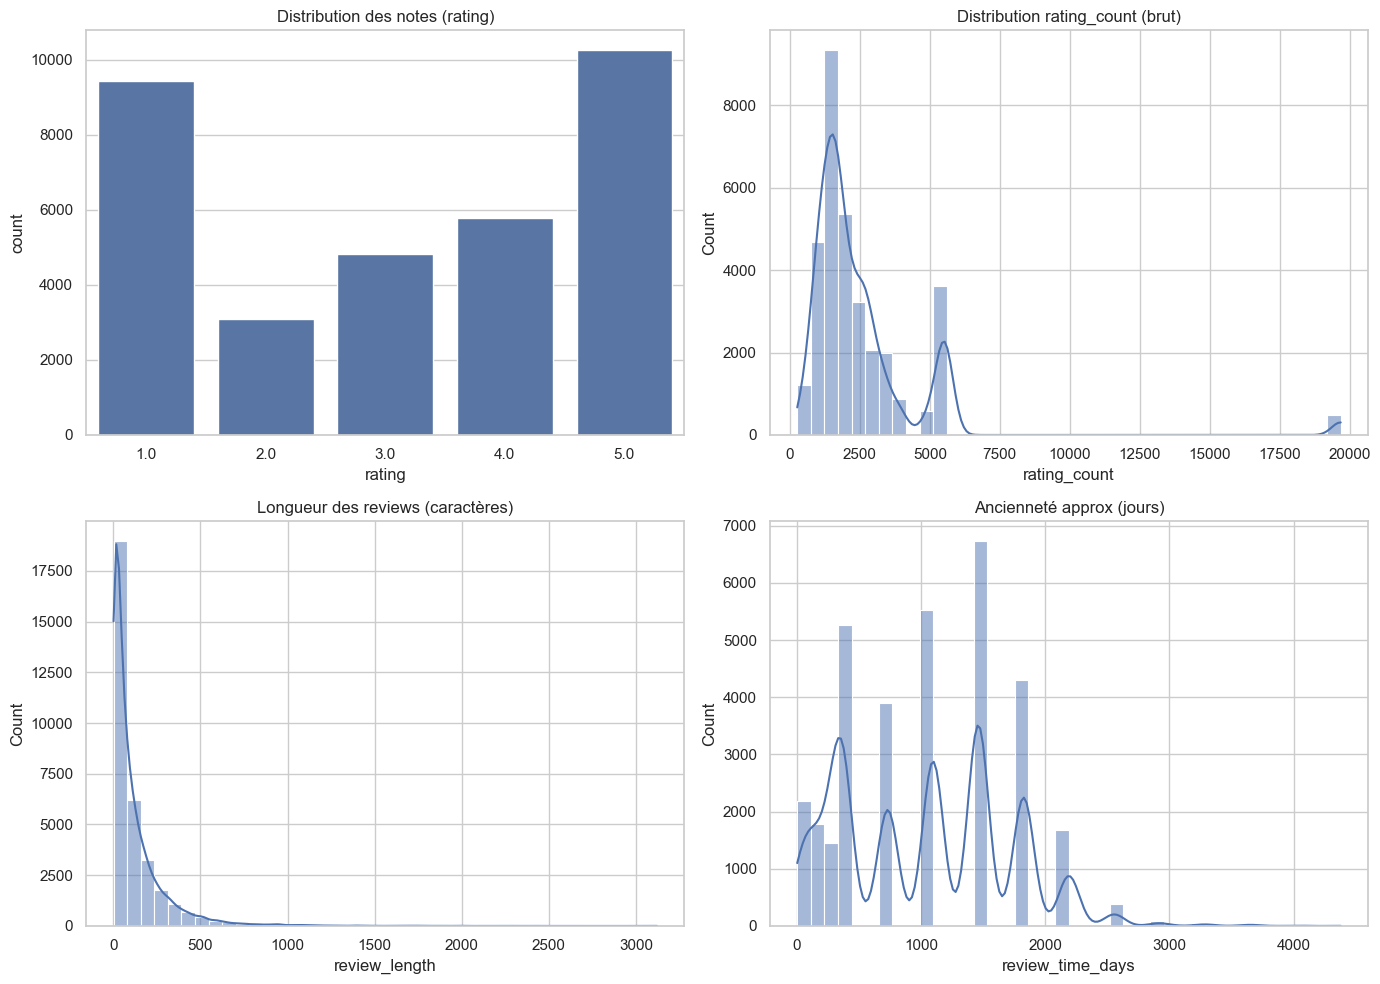

In [17]:
# Visualisation des distributions (AVANT prétraitement)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

if 'rating' in df.columns:
    sns.countplot(x='rating', data=df, ax=axes[0])
    axes[0].set_title('Distribution des notes (rating)')
else:
    axes[0].axis('off')

if 'rating_count' in df.columns:
    sns.histplot(df['rating_count'].dropna(), bins=40, kde=True, ax=axes[1])
    axes[1].set_title('Distribution rating_count (brut)')
else:
    axes[1].axis('off')

if 'review_length' in df.columns:
    sns.histplot(df['review_length'].dropna(), bins=40, kde=True, ax=axes[2])
    axes[2].set_title('Longueur des reviews (caractères)')
else:
    axes[2].axis('off')

if 'review_time_days' in df.columns:
    sns.histplot(df['review_time_days'].dropna(), bins=40, kde=True, ax=axes[3])
    axes[3].set_title('Ancienneté approx (jours)')
else:
    axes[3].axis('off')

plt.tight_layout()
plt.show()

## 7) Prétraitement (valeurs manquantes + standardisation)
Imputation des variables numériques (médiane) et standardisation (z-score).

In [18]:
# Prétraitement: gestion NA + standardisation (numériques)
numeric_cols = [c for c in ['latitude', 'longitude', 'rating_count', 'review_time_days', 'review_length'] if c in df.columns]
print('Numeric cols:', numeric_cols)

df_num_before = df[numeric_cols].copy()

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

num_imputed = imputer.fit_transform(df_num_before)
num_scaled = scaler.fit_transform(num_imputed)

df_num_after = pd.DataFrame(num_scaled, columns=[f'{c}_z' for c in numeric_cols], index=df.index)

df_pre = df.copy()
for c in numeric_cols:
    # version imputée (non-scalée) pour garder un dataset propre
    df_pre[c] = num_imputed[:, numeric_cols.index(c)]

df_pre = pd.concat([df_pre, df_num_after], axis=1)
display(df_pre[[*numeric_cols, *[f'{c}_z' for c in numeric_cols]]].head(5))

print('Missing après imputation (num):')
display(df_pre[numeric_cols].isna().mean().to_frame('missing_ratio'))

Numeric cols: ['latitude', 'longitude', 'rating_count', 'review_time_days', 'review_length']


,latitude,longitude,rating_count,review_time_days,review_length,latitude_z,longitude_z,rating_count_z,review_time_days_z,review_length_z
0,30.460718,-97.792874,1240.0,90.0,260.0,-0.750594,-0.444628,-0.535296,-1.406471,0.784532
1,30.460718,-97.792874,1240.0,5.0,237.0,-0.750594,-0.444628,-0.535296,-1.532878,0.654624
2,30.460718,-97.792874,1240.0,5.0,364.0,-0.750594,-0.444628,-0.535296,-1.532878,1.371942
3,30.460718,-97.792874,1240.0,30.0,104.0,-0.750594,-0.444628,-0.535296,-1.495700,-0.096583
4,30.460718,-97.792874,1240.0,60.0,312.0,-0.750594,-0.444628,-0.535296,-1.451085,1.078237


Missing après imputation (num):


,missing_ratio
latitude,0.0
longitude,0.0
rating_count,0.0
review_time_days,0.0
review_length,0.0


## 8) Comparaison avant / après prétraitement
Graphiques comparatifs pour visualiser l'effet de la standardisation sur les distributions (avant vs après).

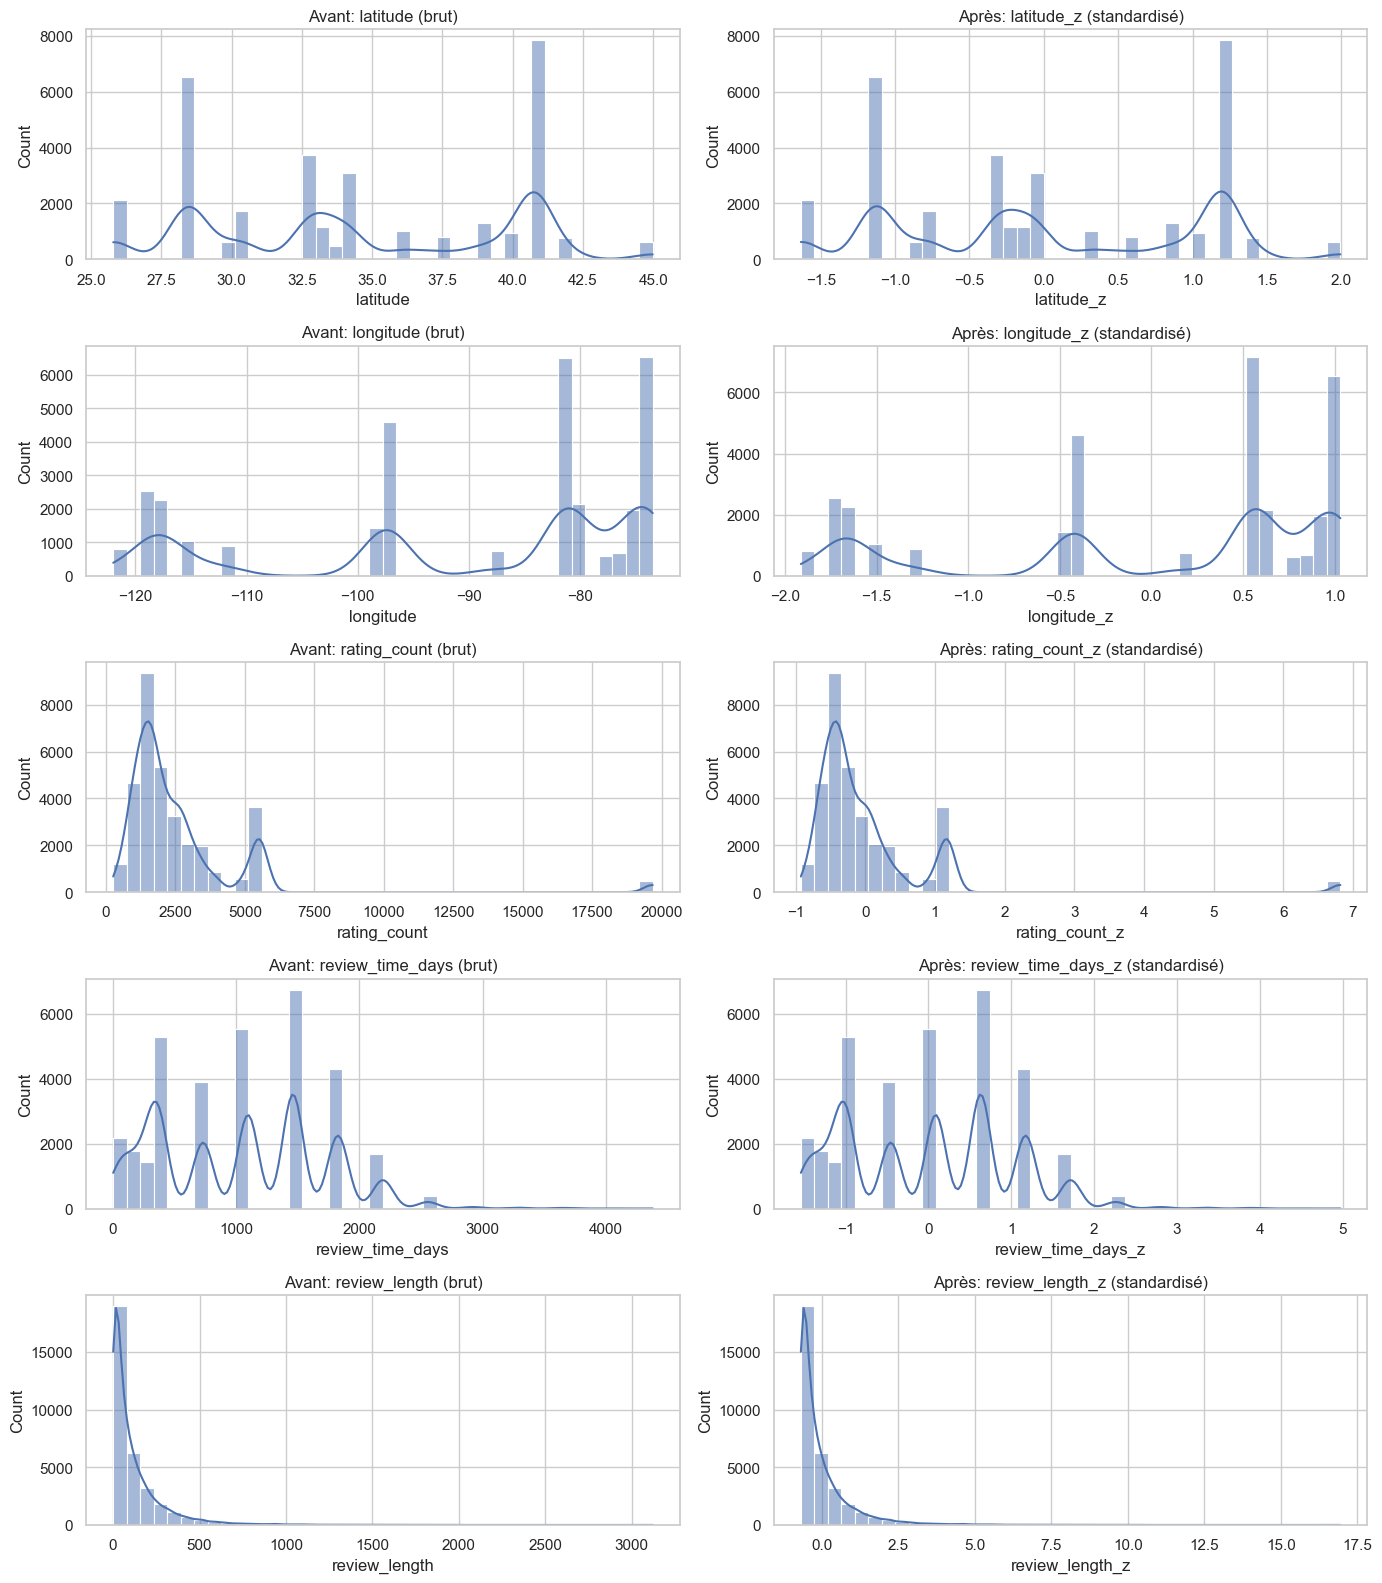

In [19]:
# Graphe comparatif: AVANT vs APRES (standardisation)
# On compare les distributions des colonnes numériques brutes vs leurs versions z-score
if numeric_cols:
    fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(14, 3.2 * len(numeric_cols)))
    if len(numeric_cols) == 1:
        axes = np.array([axes])

    for i, c in enumerate(numeric_cols):
        sns.histplot(df_num_before[c].dropna(), bins=40, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Avant: {c} (brut)')

        sns.histplot(df_pre[f'{c}_z'].dropna(), bins=40, kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f'Après: {c}_z (standardisé)')

    plt.tight_layout()
    plt.show()
else:
    print('Aucune colonne numérique détectée pour la comparaison avant/après.')

## 9) Split train / validation / test
Séparation stratifiée (sur `rating`) en 70/15/15 et vérification des distributions.

In [20]:
# Séparation train / validation / test
# Hypothèse simple: target = rating (1..5).
# On garde les features brutes + features num imputées + versions z-score si besoin pour ML ensuite.

assert 'rating' in df_pre.columns, 'Colonne target `rating` manquante.'

df_ml = df_pre.dropna(subset=['rating']).copy()
df_ml['rating'] = df_ml['rating'].astype(int)

feature_cols = []
for c in ['review', 'store_name', 'category', 'store_address']:
    if c in df_ml.columns:
        feature_cols.append(c)

# Ajoute les features numériques imputées
for c in numeric_cols:
    if c in df_ml.columns:
        feature_cols.append(c)
    zc = f'{c}_z'
    if zc in df_ml.columns:
        feature_cols.append(zc)

X = df_ml[feature_cols]
y = df_ml['rating']

# 70% train, 15% val, 15% test
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp
)

print('Shapes:')
print('  Train:', X_train.shape, y_train.shape)
print('  Val  :', X_val.shape, y_val.shape)
print('  Test :', X_test.shape, y_test.shape)

# Vérif distribution du rating
dist = pd.DataFrame({
    'train_%': y_train.value_counts(normalize=True).sort_index() * 100,
    'val_%': y_val.value_counts(normalize=True).sort_index() * 100,
    'test_%': y_test.value_counts(normalize=True).sort_index() * 100,
}).fillna(0)
display(dist)

Shapes:
  Train: (23377, 14) (23377,)
  Val  : (5009, 14) (5009,)
  Test : (5010, 14) (5010,)


,train_%,val_%,test_%
rating,,,
1,28.241434,28.229187,28.243513
2,9.239851,9.243362,9.241517
3,14.424434,14.434019,14.431138
4,17.328999,17.328808,17.325349
5,30.765282,30.764624,30.758483
